In [63]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [64]:
batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

## minibatch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

50000 10000 10000


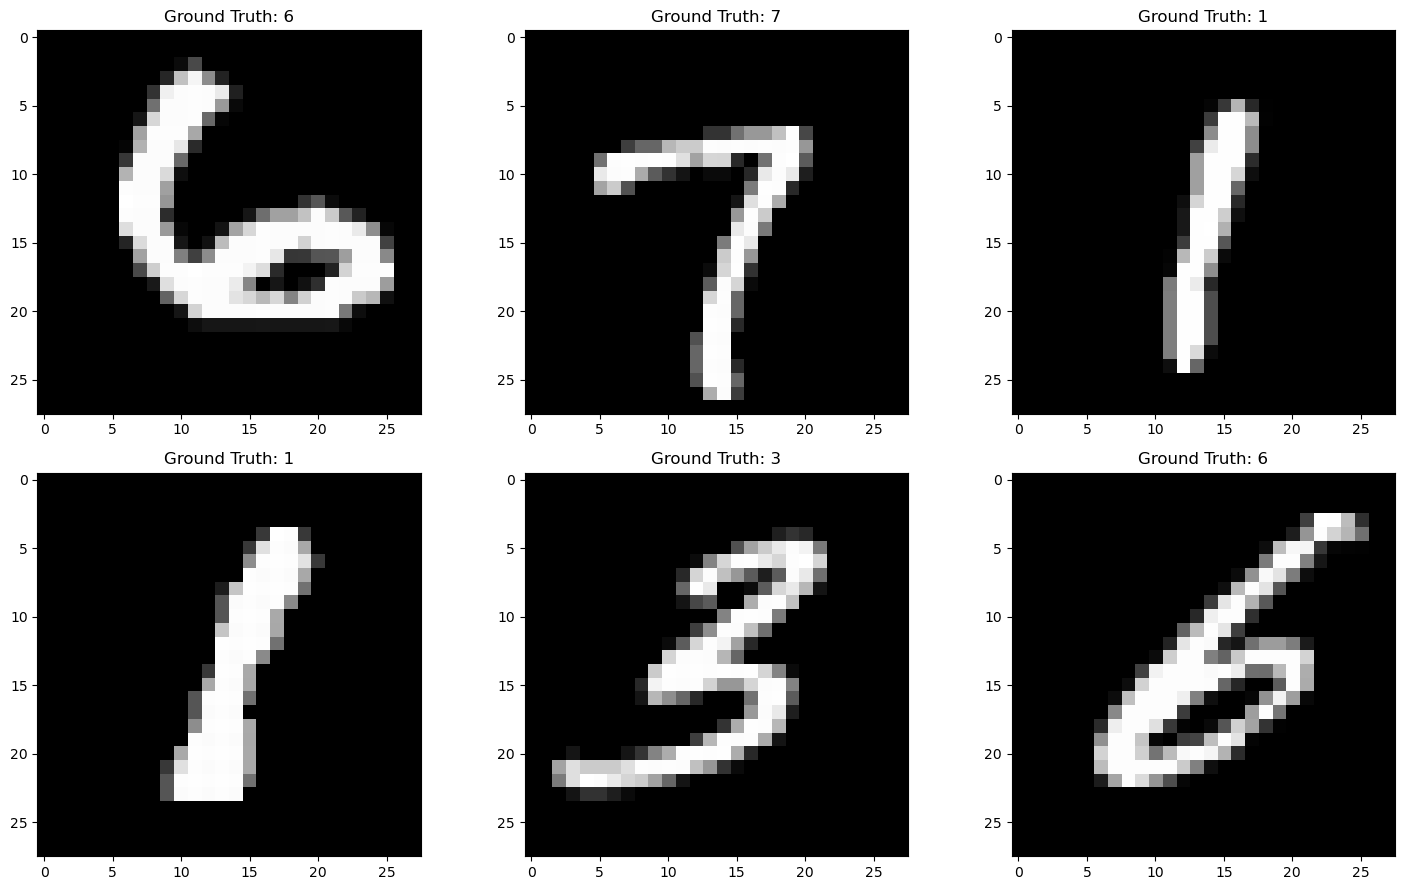

In [65]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [66]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features = 784, out_features = 10, bias = True)

    def forward(self, x):
        x = self.linear(x)
        return x

class MLPModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features = in_dim, out_features = hid_dim)
        self.linear2 = nn.Linear(in_features = hid_dim, out_features = out_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class MLPModel2(nn.Module):
    def __init__(self, input, output, hidden_nodes):
        super(MLPModel2, self).__init__()

        self.linear1 = nn.Linear(in_features = input, out_features = hidden_nodes[0], bias = True)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_nodes) - 1):
            self.hidden.append(nn.Linear(hidden_nodes[i], hidden_nodes[i+1], bias = True))
        self.linear2 = nn.Linear(hidden_nodes[-1], out_features = output, bias = True)
        self.relu = nn.ReLu()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        for layer in self.hidden:
            x = self.relu(layer(x))
        x = self.linear2(x)
        return x

 
    def __init__(self, nodes_list, output):
        super(MLPModel3, self).__init__()
        self.hidden = nn.ModuleList()
        for i in range(len(nodes_list)-1):
            self.hidden.append(nn.Linear(nodes_list[i], nodes_list[i+1], bias=True))
        self.linear = nn.Linear(nodes_list[-1], output, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.hidden:
            x = self.relu(layer(x))
        x = self.linear(x)
        return x


In [67]:
cls_loss = nn.CrossEntropyLoss()

In [70]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

# ====== Construct Model ====== #
list = [784, 100]
out = 10
model = MLPModel3(list, out)
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    ts = time.time()
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        input_X = input_X.to(device)
        true_y = true_y.to(device)
        pred_y = model(input_X)
        

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            input_X = input_X.to(device)
            true_y = true_y.to(device)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct = correct + pred_y.eq(true_y).sum()
            
        acc = correct.item() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
        te = time.time()
        
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%, time: {:3.1f}'.format(i, train_loss, val_loss, acc*100, te - ts ))

cuda:0
Number of 79510 parameters
Epoch: 0, Train Loss: 1.1707781938945545, Val Loss: 0.6329066266741934, Test Acc: 86.42%, time: 6.8
Epoch: 1, Train Loss: 0.5143323253335246, Val Loss: 0.45032368053363847, Test Acc: 88.92%, time: 6.9
Epoch: 2, Train Loss: 0.4091645529126877, Val Loss: 0.3883816843168645, Test Acc: 89.99000000000001%, time: 6.7
Epoch: 3, Train Loss: 0.364145743915492, Val Loss: 0.3548157901703557, Test Acc: 90.66%, time: 7.0
Epoch: 4, Train Loss: 0.3367120585859279, Val Loss: 0.33283193126509464, Test Acc: 91.2%, time: 7.3
Epoch: 5, Train Loss: 0.3173259877030502, Val Loss: 0.31549976520900486, Test Acc: 91.61%, time: 7.6
Epoch: 6, Train Loss: 0.30192255592712053, Val Loss: 0.30276419976844066, Test Acc: 91.97999999999999%, time: 7.3
Epoch: 7, Train Loss: 0.28909414703659997, Val Loss: 0.290804690009431, Test Acc: 92.19000000000001%, time: 7.2
Epoch: 8, Train Loss: 0.2782225215145389, Val Loss: 0.2800282698266114, Test Acc: 92.56%, time: 7.3
Epoch: 9, Train Loss: 0.268

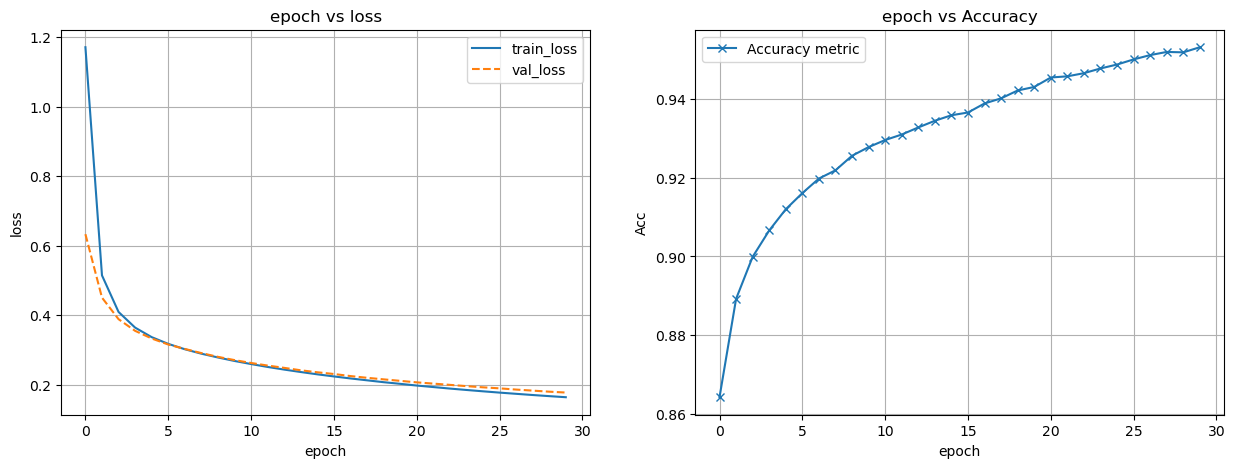

In [72]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()